# Volumetric inverse rendering

## Overview

In this tutorial, we use Mitsuba's differentiable volumetric path tracer to optimize a scattering volume to match a set of (synthetic) reference images. We will optimize a 3D volume density that's stored on a regular grid. The optimization will account for both direct and indirect illumination by using [path replay backpropagation][1] to compute derivatives of delta tracking and volumetric multiple scattering. The reconstructed volume parameters can then for example be re-rendered using novel illumination conditions.


<div class="admonition important alert alert-block alert-success">

🚀 **You will learn how to:**
    
<ul>
  <li>Construct a scene with volumes</li>
  <li>Optimize a volume grid to match a set of reference images</li>
  <li>Upscale the optimized parameters during the optimization</li>
</ul>
    
</div>

[1]: https://rgl.epfl.ch/publications/Vicini2021PathReplay


## Setup

As always, we start with the usual imports and set a variant that supports automatic differentation.

In [1]:
import matplotlib.pyplot as plt 

import drjit as dr
import mitsuba as mi

mi.set_variant('llvm_ad_rgb')

## Creating multiple sensors

We cannot hope to obtain a robust volumetric reconstruction using only a single reference image. Multiple viewpoints are needed to sufficiently constrain the reconstructed volume density.  Using a multi-view optimization we can recover volume parameters that generalize to novel views (and illumination conditions).

In this tutorial, we use 5 sensors placed on a half circle around the origin. For the simple optimization in this tutorial this is sufficient, but more complex scenes may require using significantly more views (e.g., using 50-100 sensors is not unreasonable).

In [2]:
from mitsuba import ScalarTransform4f as T

sensor_count = 5
sensors = []

for i in range(sensor_count):
    angle = 180.0 / sensor_count * i - 90.0
    sensor_rotation = T.rotate([0, 1, 0], angle)
    sensor_to_world = T.look_at(target=[0, 0, 0], origin=[0, 0, 4], up=[0, 1, 0])
    sensors.append(mi.load_dict({
        'type': 'perspective',
        'fov': 45,
        'to_world': sensor_rotation @ sensor_to_world,
        'film': {
            'type': 'hdrfilm',
            'width': 64, 'height': 64,
            'filter': {'type': 'tent'}
        }
    }))


## Rendering synthetic reference images

We will now setup a simple scene with a constant environment illumination and a reference volume placed at the origin. The heterogenous volume is instantiated inside of a cube. We assign the `null` BSDF to the cube's surface, since we do not want the cube's surface to interact with light in any way (i.e., the surface should be invisible). To learn more about volume rendering in Mitsuba, please refer to the [plugin documentation][1].

We then render this scene using the previously created sensors and store the resulting images in a list for later use.


[1]: https://mitsuba3.readthedocs.io/en/latest/src/generated/plugins_media.html#heterogeneous-medium-heterogeneous

In [3]:
scene_dict = {
    'type': 'scene',
    'integrator': {'type': 'prbvolpath'},
    'object': {
        'type': 'cube',
        'bsdf': {'type': 'null'},
        'interior': {
            'type': 'heterogeneous',
            'sigma_t': {
                'type': 'gridvolume',
                'filename': '../scenes/volume.vol',
                'to_world': T.rotate([1, 0, 0], -90).scale(2).translate(-0.5)
            },
            'scale': 40
        }
    },
    'emitter': {'type': 'constant'}
}

scene_ref = mi.load_dict(scene_dict)

2022-07-01 13:57:55 WARN main [Scene] No sensors found! Instantiating a perspective camera..

In [4]:
ref_images = [mi.render(scene_ref, sensor=sensors[i], spp=512) for i in range(sensor_count)]

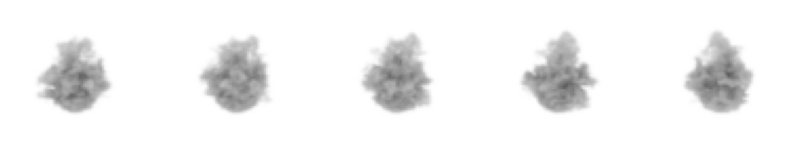

In [5]:
fig, axs = plt.subplots(1, sensor_count, figsize=(14, 4))
for i in range(sensor_count):
    axs[i].imshow(mi.util.convert_to_bitmap(ref_images[i]))
    axs[i].axis('off')

## Setting up the optimization scene
Our goal is now to optimize a 3D volume density (also called extinction) to match the previously generated reference images. For this we create a second scene, where we replace the reference volume by a simple uniform initialization. 

To initialize a volume grid from Python, we use the [<code>VolumeGrid</code>][2] object in conjunction with [<code>TensorXf</code>][3]. The `VolumeGrid` class is responsible for loading and writing volumes from disk, similar to the `Bitmap` class for images. Using the `grid` property of the [<code>gridvolume</code>][4] plugin, it is possible to pass it directly to the plugin constructor in Python.

We initialize the extinction `sigma_t` to a low constant value, (e.g. `0.002`). This tends to help the optimization process, as it seems to be easier for the optimizer to increase the volume density rather than remove parts of a very dense volume. 

Note that we use a fairly small initial volume resolution here. This is done on purpose since we will upsample the volume grid during the actual optimization process. As explained later, this typically improves the convexity of the volume optimization problem.

[1]: https://mitsuba3.readthedocs.io/en/latest/src/generated/plugins_media.html#heterogeneous-medium-heterogeneous
[2]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.VolumeGrid
[3]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.TensorXf
[4]: https://mitsuba3.readthedocs.io/en/latest/src/generated/plugins_media.html#grid-based-volume-data-source-gridvolume

In [6]:
v_res = 16

# Modify the scene dictionary
scene_dict['object'] = {
    'type': 'cube',
    'interior': {
        'type': 'heterogeneous',
        'sigma_t': {
            'type': 'gridvolume',
            'grid': mi.VolumeGrid(dr.full(mi.TensorXf, 0.002, (v_res, v_res, v_res, 1))),
            'to_world': T.translate(-1).scale(2.0)
        },
        'scale': 40.0,
    },
    'bsdf': {'type': 'null'}
}

scene = mi.load_dict(scene_dict)

2022-07-01 13:58:08 WARN main [Scene] No sensors found! Instantiating a perspective camera..

We load the modified scene and render it for all view angles. Those are going to be our initial image in the optimization process.

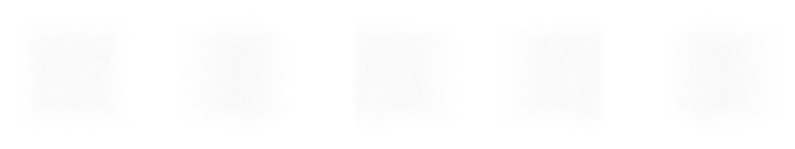

In [7]:
init_images = [mi.render(scene, sensor=sensors[i], spp=128) for i in range(sensor_count)]

fig, axs = plt.subplots(1, sensor_count, figsize=(14, 4))
for i in range(sensor_count):
    axs[i].imshow(mi.util.convert_to_bitmap(init_images[i]))
    axs[i].axis('off')

## Optimization

We instantiate an `Adam` optimizer and load the `sigma_t` grid data as parameter to be optimized.

In [8]:
params = mi.traverse(scene)

key = 'object.interior_medium.sigma_t.data'

opt = mi.ad.Adam(lr=0.02)
opt[key] = params[key]
params.update(opt)

[(GridVolume[
    to_local = [[0.5, 0, 0, 0.5],
                [0, 0.5, 0, 0.5],
                [0, 0, 0.5, 0.5],
                [0, 0, 0, 1]],
    bbox = BoundingBox3f[
      min = [-1, -1, -1],
      max = [1, 1, 1]
    ],
    dimensions = [16, 16, 16],
    max = 0.002,
    channels = 1
  ],
  {'data'}),
 (HeterogeneousMedium[
    albedo  = ConstVolume[
      to_local = [[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]],
      value = UniformSpectrum[value=[0.75]]
    ]
    sigma_t = GridVolume[
      to_local = [[0.5, 0, 0, 0.5],
                  [0, 0.5, 0, 0.5],
                  [0, 0, 0.5, 0.5],
                  [0, 0, 0, 1]],
      bbox = BoundingBox3f[
        min = [-1, -1, -1],
        max = [1, 1, 1]
      ],
      dimensions = [16, 16, 16],
      max = 0.002,
      channels = 1
    ]
    scale   = 40
  ],
  {'sigma_t'}),
 (Cube[
    name = "cube",
    bbox = BoundingBox3f[
      min = [-1, -1, -1],
      max 

We then run the optimization loop for a few iterations, similar to the other tutorials.

In [9]:
for it in range(20):
    total_loss = 0.0
    for sensor_idx in range(sensor_count):
        # Perform the differentiable light transport simulation
        img = mi.render(scene, params, sensor=sensors[sensor_idx], spp=8, seed=it)
        
        # L2 loss function
        loss = dr.mean(dr.sqr(img - ref_images[sensor_idx]))
        
        # Backpropagate gradients
        dr.backward(loss)

        # Take a gradient step
        opt.step()
        
        # Clamp the optimized density values. Since we used the `scale` parameter 
        # when instantiating the volume, we are in fact optimizing extinction 
        # in a range from [1e-6 * scale, scale].
        opt[key] = dr.clamp(opt[key], 1e-6, 1.0)
        
        # Propagate changes to the scene
        params.update(opt)
        
        total_loss += loss[0]
    print(f"Iteration {it:02d}: error={total_loss:6f}", end='\r')

## Intermediate results

We have only performed a few iterations so far and can take a look at the current results.

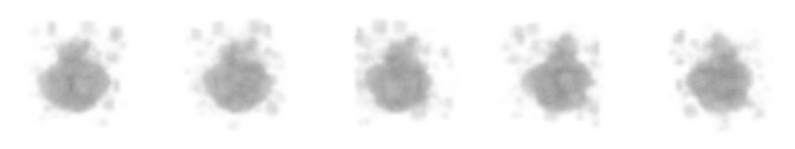

In [10]:
intermediate_images = [mi.render(scene, sensor=sensors[i], spp=128) for i in range(sensor_count)]

fig, axs = plt.subplots(1, sensor_count, figsize=(14, 4))
for i in range(sensor_count):
    axs[i].imshow(mi.util.convert_to_bitmap(intermediate_images[i]))
    axs[i].axis('off')

## Volume upsampling

The results above don't look great. One reason is the low resolution of the optimized volume grid. Let's try to increase the resolution of the current grid and continue the optimization for a few more iterations. In practice it is almost always beneficial to leverage such a "multi-resolution" approach. At low resolution, the optimization will recover the overall shape, exploring a much simpler solution landscape. Moving on to a volume with a higher resolution allows recovering additional detail, while using the coarser solution as a starting point.

Luckily Dr.Jit provides [<code>dr.upsample()</code>][1], a functions for up-sampling tensor and texture data. We can easily create a higher resolution volume by passing the current optimzed tensor and specifying the desired shape (must be powers of two when upsampling `TensorXf`).

[1]: https://drjit.readthedocs.io/en/latest/src/api_reference.html#drjit.upsample

In [11]:
opt[key] = dr.upsample(opt[key], shape=(64, 64, 64))
params.update(opt)

[(GridVolume[
    to_local = [[0.5, 0, 0, 0.5],
                [0, 0.5, 0, 0.5],
                [0, 0, 0.5, 0.5],
                [0, 0, 0, 1]],
    bbox = BoundingBox3f[
      min = [-1, -1, -1],
      max = [1, 1, 1]
    ],
    dimensions = [64, 64, 64],
    max = 0.439475,
    channels = 1
  ],
  {'data'}),
 (HeterogeneousMedium[
    albedo  = ConstVolume[
      to_local = [[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]],
      value = UniformSpectrum[value=[0.75]]
    ]
    sigma_t = GridVolume[
      to_local = [[0.5, 0, 0, 0.5],
                  [0, 0.5, 0, 0.5],
                  [0, 0, 0.5, 0.5],
                  [0, 0, 0, 1]],
      bbox = BoundingBox3f[
        min = [-1, -1, -1],
        max = [1, 1, 1]
      ],
      dimensions = [64, 64, 64],
      max = 0.439475,
      channels = 1
    ]
    scale   = 40
  ],
  {'sigma_t'}),
 (Cube[
    name = "cube",
    bbox = BoundingBox3f[
      min = [-1, -1, -1],
    

Rendering the new, upsampled volume we can already notice a slight difference in the apparent sharpness. This is due to the *trilinear* interpolation of density values that is used by the volumetric path tracer.

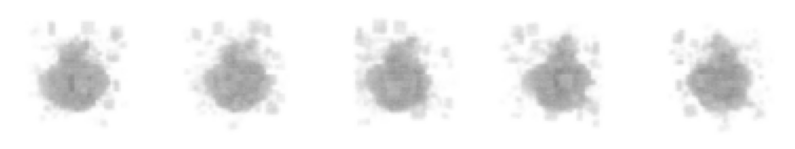

In [12]:
upscale_images = [mi.render(scene, sensor=sensors[i], spp=128) for i in range(sensor_count)]

fig, axs = plt.subplots(1, sensor_count, figsize=(14, 4))
for i in range(sensor_count):
    axs[i].imshow(mi.util.convert_to_bitmap(upscale_images[i]))
    axs[i].axis('off')

## Continuing the optimization

Let's now run our optimization loop for a few more iterations with the upscaled volume grid.

<div class="admonition important alert alert-block alert-info">

🗒 **Note**
    
The optimizer automatically resets the internal state (e.g., momentum) associated to the optimized variable when it detects a size change.

</div>

In [13]:
for it in range(10):
    total_loss = 0.0
    for sensor_idx in range(sensor_count):
        img = mi.render(scene, params, sensor=sensors[sensor_idx], spp=128, seed=it)
        loss = dr.mean(dr.sqr(img - ref_images[sensor_idx]))
        dr.backward(loss)
        opt.step()
        opt[key] = dr.clamp(opt[key], 1e-6, 1.0)
        params.update(opt)
        total_loss += loss[0]
    print(f"Iteration {it:02d}: error={total_loss:6f}", end='\r')

## Final results

Finally we can render the final volume from the different view points and compare the images to the reference images.

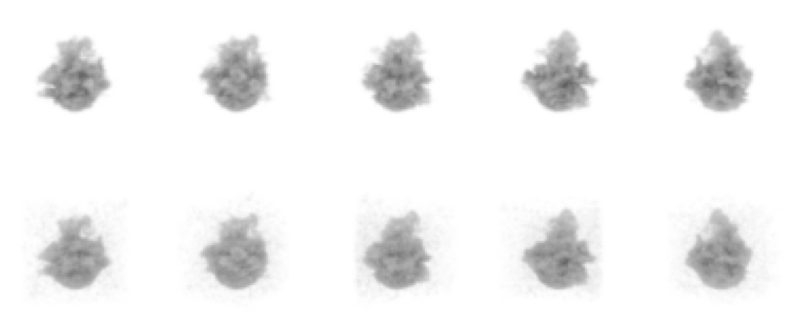

In [14]:
final_images = [mi.render(scene, sensor=sensors[i], spp=512) for i in range(sensor_count)]

fig, axs = plt.subplots(2, sensor_count, figsize=(14, 6))
for i in range(sensor_count):
    axs[0][i].imshow(mi.util.convert_to_bitmap(ref_images[i]))
    axs[0][i].axis('off')
    axs[1][i].imshow(mi.util.convert_to_bitmap(final_images[i]))
    axs[1][i].axis('off')

Of course the results could be further improved by taking more iterations or adopting other advanced optimization schemes, such as multi-resolution rendering where the rendering resolution is increased throughout the optimization process. Additionally, it can sometimes be beneficial to add a sparsity (e.g., an $L_1$ loss on the density values) or smoothness prior (e.g., a total variation regularizer penalizing differences between neighboring voxels).



## See also

- [<code>mitsuba.ad.integrators.prbvolpath</code>](https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.integrators.prbvolpath)
- [<code>heterogeneous</code> plugin](https://mitsuba3.readthedocs.io/en/latest/src/generated/plugins_media.html#heterogeneous-medium-heterogeneous)
- [<code>gridvolume</code> plugin](https://mitsuba3.readthedocs.io/en/latest/src/generated/plugins_media.html#grid-based-volume-data-source-gridvolume)
- [<code>mitsuba.VolumeGrid</code>](https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.VolumeGrid)
- [<code>mitsuba.TensorXf</code>](https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.TensorXf)
- [<code>dr.upsample</code>](https://drjit.readthedocs.io/en/latest/src/api_reference.html#upsample)